# Modelling

In this final notebook, I will select a model to use and to recommend for classifying ice cream reviews. The data has already been preprocessed from my [previous notebook](https://github.com/isabelanyc/Ice-Cream-Reviews/blob/main/notebooks/3_preprocessing.ipynb). Once the modelling has been completed, I'll give a breif summary of the work that has been done and show the overall performance of the model.

I'll start by loading in some libraries that will be handy here.

In [11]:
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score

## Load the Data

Next, I'll load the preprocessed data that contains all the textual information, as a reference. Then I'll load in the testing and training data that was split and transformed using TF-IDF.

In [12]:
preprocessed_data = pd.read_csv('../data/preprocessed_data.csv', index_col=0)

In [13]:
preprocessed_data.head(3)

,text,good_review
0,breyers carb bar i breyers carb smart vanilla ...,Bad
1,my favorite this favorite gelato far this flav...,Good
2,my favorite his absolute favorite flavor pleas...,Good


In [14]:
X = preprocessed_data.copy()
X.drop(['text'], axis=1, inplace=True)
y = preprocessed_data['good_review']

In [15]:
X_train = pd.read_csv('../data/train.csv', index_col=0).iloc[:, :-1]
y_train = pd.read_csv('../data/train.csv', index_col=0)['good_review']
X_test = pd.read_csv('../data/test.csv', index_col=0).iloc[:, :-1]
y_test = pd.read_csv('../data/test.csv', index_col=0)['good_review']

## Model Selection

Now its time to get down to modelling. I have selected 4 models to test plus one dummy model as a baseline:

* Multinomial Naive Bayes
* Passive Aggressive Classifier
* Logistic Regression
* SVM

I have selected these four since I know they run relatively quickly and I have experience using then before. Each of these models will be cross validated and tuned using `RandomizedSearchCV` with 10 folds. Whichever model performs the best, will be the one I select.

### Dummy Classifier

Before I even begin modelling, I'll start with a baseline model, `DummyClassifier`. The results of this model will serve a reference point for the performance of all the ML models. 

In [16]:
dummy = DummyClassifier(strategy='stratified')

In [17]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [18]:
y_predict_dummy = dummy.predict(X_test)

In [19]:
dummy_report = classification_report(y_test, y_predict_dummy)
print(dummy_report)

              precision    recall  f1-score   support

         Bad       0.21      0.22      0.21      1379
        Good       0.79      0.78      0.78      5124

    accuracy                           0.66      6503
   macro avg       0.50      0.50      0.50      6503
weighted avg       0.67      0.66      0.66      6503



Performance is just about as I expected... pretty bad. Let's see how the rest of the models perform.

### Multinomial Naive Bayes

First up is Naive Bayes. Naive Bayes can perform quite well for NLP tasks and is very fast. I expect this to perform farily well. I will only tune the alpha parameter.

In [20]:
start_time = time.time()
nb = MultinomialNB()

In [21]:
alpha = [i/10 for i in range(0, 11)]
param_dist = {"alpha": alpha}

In [22]:
rand_search = RandomizedSearchCV(estimator=nb, param_distributions=param_dist, cv=10, random_state=1)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=1)

In [23]:
best_nb = rand_search.best_estimator_

In [24]:
print(best_nb)

MultinomialNB(alpha=0.0)


In [25]:
nb = best_nb
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)
end_time = time.time()

In [26]:
nb_report = classification_report(y_test, y_predict_nb)
print(nb_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.94      0.59      0.72      1379
        Good       0.90      0.99      0.94      5124

    accuracy                           0.90      6503
   macro avg       0.92      0.79      0.83      6503
weighted avg       0.91      0.90      0.90      6503

Execution time: 0.25707523425420126 min


This is a pretty good f1. The f1 for the *Bad* class could certainly be better. The recall is also on the lower end. Maybe the next models will do a better job. On the bright side, this took barely any time to complete.

### Passive Aggressive Classifier

The next model is a Passive Aggressive Classifier. I used this model in a [previous project](https://github.com/isabelanyc/Fake-Job-Posting-Prediction) and it performed fairly wel. When I last used it, I mentioned that I actually did not know much about how this model works. I can now say that I have doen my research and can recommend taking a look at paper by [Crammer et al](https://jmlr.csail.mit.edu/papers/volume7/crammer06a/crammer06a.pdf). I will tune the `fit_intercept` and `max_iter` hyperparmeters.

In [27]:
start_time = time.time()
pag = PassiveAggressiveClassifier()

In [28]:
fit_intercept = [False, True]
max_iter = [i*100 for i in range(1,21)]
param_dist = {"fit_intercept": fit_intercept,
              "max_iter": max_iter}

In [29]:
rand_search = RandomizedSearchCV(estimator=PassiveAggressiveClassifier(), param_distributions=param_dist, cv=10, random_state=1)

In [30]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=PassiveAggressiveClassifier(),
                   param_distributions={'fit_intercept': [False, True],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700, 800, 900, 1000,
                                                     1100, 1200, 1300, 1400,
                                                     1500, 1600, 1700, 1800,
                                                     1900, 2000]},
                   random_state=1)

In [31]:
best_pag = rand_search.best_estimator_

In [32]:
print(best_pag)

PassiveAggressiveClassifier(max_iter=700)


In [33]:
pag = best_pag
pag.fit(X_train, y_train)
y_predict_pag = pag.predict(X_test)
end_time = time.time()

In [34]:
pag_report = classification_report(y_test, y_predict_pag)
print(pag_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.84      0.78      0.81      1379
        Good       0.94      0.96      0.95      5124

    accuracy                           0.92      6503
   macro avg       0.89      0.87      0.88      6503
weighted avg       0.92      0.92      0.92      6503

Execution time: 1.8186864813168844 min


This is slightly better than the previous model, though the run time is a bit longer, but still not much of a worry. 

### Logistic Regression

Next up is the trusty logitic regression. The only parameter I will tune is the `l1_ratio`.

In [35]:
start_time = time.time()
lr = LogisticRegression()

In [36]:
dual = [False]
l1_ratio = [i/10 for i in range(0, 10)]
param_dist = {"dual": dual,
              "l1_ratio": l1_ratio}

In [37]:
rand_search = RandomizedSearchCV(lr, param_distributions=param_dist, scoring='f1', cv=10, random_state=1)

In [38]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'dual': [False],
                                        'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5, 0.6, 0.7, 0.8, 0.9]},
                   random_state=1, scoring='f1')

In [39]:
best_lr = rand_search.best_estimator_
print(rand_search.best_estimator_)

LogisticRegression(l1_ratio=0.0)


In [40]:
y_predict_lr = best_lr.predict(X_test)
end_time = time.time()

In [41]:
lr_report = classification_report(y_test, y_predict_lr)
print(lr_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.91      0.76      0.83      1379
        Good       0.94      0.98      0.96      5124

    accuracy                           0.93      6503
   macro avg       0.92      0.87      0.89      6503
weighted avg       0.93      0.93      0.93      6503

Execution time: 1.164543620745341 min


Leave it to classic logistic regression to be the best performing model so far. This has the best f1 of the three so far, but also has the longest run time -- just something to note.

### SVM

The last model I will try is SVM. I am going to tune a few parameters here: `kernel`, `shrinking` and `decision_function_shape`.

In [42]:
start_time = time.time()
svm = SVC()

In [43]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
shrinking = [True, False]
decision_function_shape = ['ovo', 'ovr']
param_dist = {"kernel": kernel,
              "shrinking": shrinking,
              "decision_function_shape": decision_function_shape}
param_dist = {}

In [44]:
rand_search = RandomizedSearchCV(svm, param_distributions=param_dist, scoring='f1', n_iter=5, cv=10, random_state=1)

In [45]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=5, param_distributions={},
                   random_state=1, scoring='f1')

In [46]:
best_svm = rand_search.best_estimator_
print(rand_search.best_estimator_)

SVC()


In [47]:
y_predict_svm = best_svm.predict(X_test)
end_time = time.time()

In [48]:
svm_report = classification_report(y_test, y_predict_svm)
print(svm_report)
print("Execution time: %s min" % ((end_time - start_time)/60))

              precision    recall  f1-score   support

         Bad       0.91      0.77      0.83      1379
        Good       0.94      0.98      0.96      5124

    accuracy                           0.93      6503
   macro avg       0.92      0.88      0.90      6503
weighted avg       0.93      0.93      0.93      6503

Execution time: 11.01939785083135 min


The performance of the SVM model is pretty good, but it did take almost an hour to run. Also, it performed pretty similarly to the logistic regression model. I don't see much reason to choose this one over logistic regression.

## Summary

All of the models performed pretty well. Logistic Regression and SVM performed similarly, but Logistic Regression ran much faster. Naive Bayes performed the worst but had the fastest run time. The Passive Aggressive Classifer performed somewhere between the two in terms of speed and performance.

So if I have to choose one, I am going to go with Logisitic Regression. It is both quick and accurate.

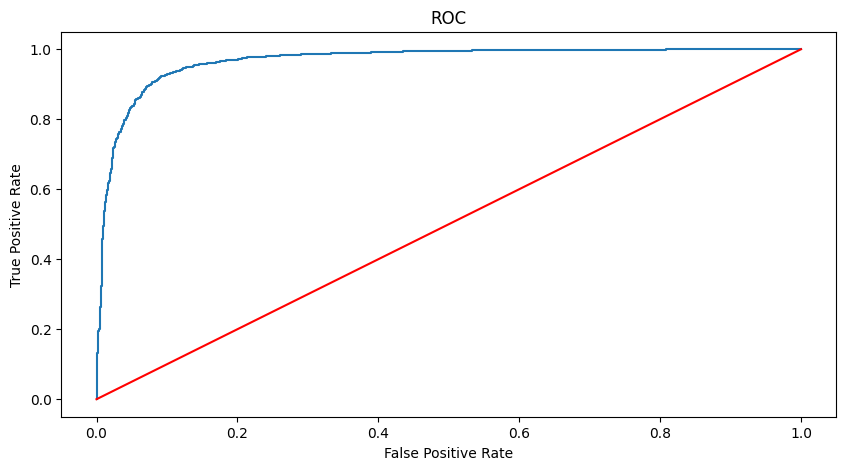

In [49]:
y_scores_lr = best_lr.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_lr, pos_label="Good")
plt.figure(figsize=(10, 5))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()